In this notebook, I will demonstrate how to use existing SDSS software to create a commissioning design using a carton that already exists in targetdb. Specifically, we will be creating a design of all-skies.

# Creating Commissioning Designs

For this example, I will demonstrate how to create a design for a carton that is already in targetdb, specifically an all-sky design. First, we have to select all skies near some field center in targetdb.

In [1]:
from sdssdb.peewee.sdss5db import targetdb

# connect to targetdb
targetdb.database.connect_from_parameters(user='sdss',
                                          host='localhost',
                                          port=7500)

True

In [2]:
from peewee import *
import numpy as np

# set search radius based on field size for APO or LCO
observatory = 'APO'
if observatory == 'APO':
    r_search = 1.49
else:
    r_serach = 0.95

# specify the field center and position angle
racen = 20.
deccen = 20.
position_angle=24.188576

# specify the commissioning cartons we want to consider
cartons = ['ops_sky_boss', 'ops_sky_apogee']

# get all of the targets in the commissioning carton near the field center
all_skies = (targetdb.Target.select(targetdb.Target.catalogid,
                                   targetdb.Target.ra,
                                   targetdb.Target.dec,
                                   targetdb.Target.pk,
                                   targetdb.CartonToTarget.priority,
                                   targetdb.CartonToTarget.value,
                                   targetdb.Cadence.label,
                                   targetdb.Carton.carton)
                    .join(targetdb.CartonToTarget)
                    .join(targetdb.Cadence, JOIN.LEFT_OUTER)
                    .switch(targetdb.CartonToTarget)
                    .join(targetdb.Carton)
                    .where((targetdb.Carton.carton.in_(cartons)) & 
                           (targetdb.Target.cone_search(racen, deccen, r_search))))

# grab the results
catalogid, ra, dec, target_pk, priority, value, cadences, carton = map(list, zip(*list(all_skies.tuples())))
catalogid = np.array(catalogid, dtype=np.int64)
ra = np.array(ra)
dec = np.array(dec)
target_pk = np.array(target_pk, dtype=np.int64)
priority = np.array(priority)
value = np.array(value)
carton = np.array(carton)
# specify the instrument for each target
instrument = np.zeros(len(carton), dtype='<U10')
instrument[carton == 'ops_sky_boss'] = 'BOSS'
instrument[carton == 'ops_sky_apogee'] = 'APOGEE'

Next, we will want to create the design using using Robostrategy. To do this, we first need to estimate the x,y coordinates of the targets in the FBS plane use coordio. To do this, we will need to also specify the observation time of the design in Julian Days.

In [3]:
from coordio.utils import radec2wokxy

# specify observation time
obsTime = 2459145.5

# convert to x,y
x, y, fieldWarn, HA, PA_coordio = radec2wokxy(ra=ra,
                                              dec=dec,
                                              coordEpoch=np.array([2457174] * len(ra)),
                                              waveName=np.array(list(map(lambda x:x.title(), instrument))),
                                              raCen=racen,
                                              decCen=deccen,
                                              obsAngle=position_angle,
                                              obsSite=observatory,
                                              obsTime=obsTime)

To visualize our possible targets for the design, below is a plot of the possible targets in the FPS focal plane:

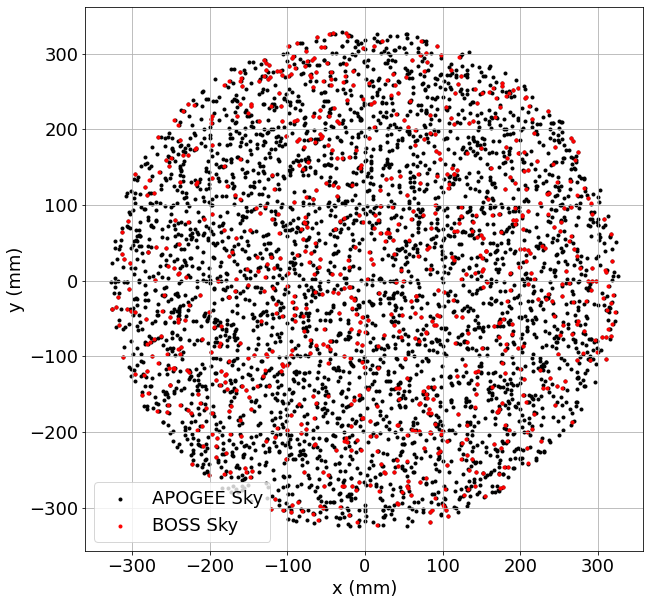

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,10))
plt.scatter(x[instrument == 'APOGEE'], y[instrument == 'APOGEE'],
            c='k', marker='.', label='APOGEE Sky')
plt.scatter(x[instrument == 'BOSS'], y[instrument == 'BOSS'],
            c='r', marker='.', label='BOSS Sky')
plt.grid()
plt.legend()
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

Now we can finally build the design. This requires that we create a specially formatted array for Robostrategy to build the design. This is demonstrated below.

In [5]:
import robostrategy.field as field
import roboscheduler.cadence as cadence

# need to load cadences before building designs
cadence.CadenceList().fromdb()

# set cadence. must be in list of loaded cadences
# set cadence here because NONEs currently for sky carton in targetdb
cadence = 'bright_1x1'

# create the field object
f = field.Field(racen=racen, deccen=deccen, pa=position_angle,
                field_cadence=cadence, observatory=observatory.lower())

# set the required skies, in this case all fibers
f.required_calibrations['sky_boss'] = 375
f.required_calibrations['sky_apogee'] = 125
f.required_calibrations['standard_boss'] = 0
f.required_calibrations['standard_apogee'] = 0

# create array for RS field
N = len(ra)
# these are datatypes from robostrategy.Field
targets_dtype = np.dtype([('ra', np.float64),
                          ('dec', np.float64),
                          ('x', np.float64),
                          ('y', np.float64),
                          ('within', np.int32),
                          ('incadence', np.int32),
                          ('priority', np.int32),
                          ('value', np.float32),
                          ('program', np.unicode_, 30),
                          ('carton', np.unicode_, 30),
                          ('category', np.unicode_, 30),
                          ('cadence', np.unicode_, 30),
                          ('fiberType', np.unicode_, 10),
                          ('catalogid', np.int64),
                          ('rsid', np.int64),
                          ('target_pk', np.int64)])

# create an empty array
targs = np.zeros(N, dtype=targets_dtype)

# fill in the relevant columns
targs['ra'] = ra
targs['dec'] = dec
targs['x'] = x
targs['y'] = y
targs['within'] = np.zeros(N, dtype=np.int32) + 1
targs['incadence'] = np.zeros(N, dtype=np.int32) + 1
targs['priority'] = priority
targs['value'] = value
# for program and carton, these are both 'CALIBRATION' for all calibration targets (i.e. sky or standard)
# for science targets, program would be bhm/mwm and carton is the carton label
# don't know how to handle this for commisioning cartons yet
targs['program'] = np.array(['CALIBRATION'] * N, dtype='<U30')
targs['carton'] = np.array(['CALIBRATION'] * N, dtype='<U30')
# set category. Can either be: 'sky_apogee', 'sky_boss', 'standard_apogee', 'standard_boss' or 'science'
category = np.zeros(len(carton), dtype='<U30')
category[carton == 'ops_sky_boss'] = 'sky_boss'
category[carton == 'ops_sky_apogee'] = 'sky_apogee'
targs['category'] = category
targs['cadence'] = np.array([cadence] * N, dtype='<U30')
targs['fiberType'] = instrument
targs['catalogid'] = catalogid
targs['rsid'] = np.arange(N, dtype=np.int64) + 1
targs['target_pk'] = target_pk

# assign targets
f.targets_fromarray(targs)

f.assign()

You can print out the results of the assigments for the design to see how close Robostrategy got to the desired design.

In [6]:
print(f.assess())

Field cadence: bright_1x1

Calibration targets:
 sky_boss (want 375): 375
 standard_boss (want 0): 0
 sky_apogee (want 125): 102
 standard_apogee (want 0): 0

Science targets:
 BOSS targets assigned: 0
 APOGEE targets assigned: 0
 Targets per epoch: 0

Carton completion:




You can also plot the resulting assignments:

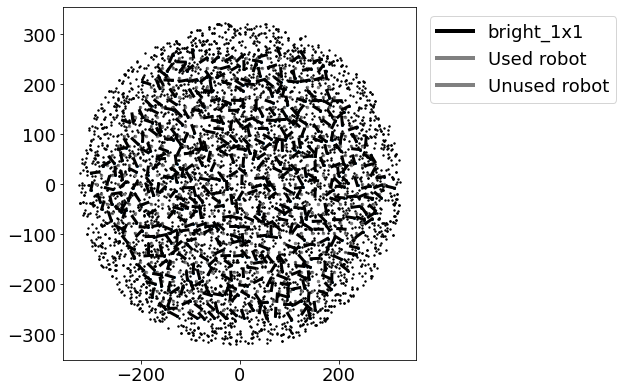

In [7]:
f.plot(iexp=0)

# Adding Commissioning Design to targetdb

Finally, if you have created a design to your liking, you can add the design to targetdb using Mugatu. To do this, we will use the results of the above design to create a mugatu.FPSDesign object:

In [8]:
from mugatu.fpsdesign import FPSDesign

# create empty arrays for input
catalogids = np.zeros(500, dtype=np.int64) - 1
ra = np.zeros(500, dtype=float) - 9999.99
dec = np.zeros(500, dtype=float) - 9999.99
fiberID = np.zeros(500, dtype=np.int64) - 1
obsWavelength = np.zeros(500, dtype='<U10')
priority = np.zeros(500, dtype=int) - 1

# add assignments to the empty arrays
for i in range(len(f.targets)):
    if f.assignments[i][2][0] != -1:
        rid = f.assignments[i][2][0]
        catalogids[rid] = f.targets[i]['catalogid']
        ra[rid] = f.targets[i]['ra']
        dec[rid] = f.targets[i]['dec']
        fiberID[rid] = rid
        obsWavelength[rid] = f.targets[i]['fiberType']
        priority[rid] = f.targets[i]['priority']

# create a mugatu.FPSDesign object that is specified as a manual design
fps_design = FPSDesign(design_pk=-1,
                       obsTime=obsTime,
                       racen=racen,
                       deccen=deccen,
                       position_angle=position_angle,
                       observatory=observatory,
                       mode_pk=None,
                       catalogids=catalogids,
                       ra=ra,
                       dec=dec,
                       fiberID=fiberID,
                       obsWavelength=obsWavelength,
                       priority=priority,
                       design_file=None,
                       manual_design=True)

Before adding the design to targetdb, we will want to validate the design one more time to ensure that there are no collisions that Robostratgegy missed:

In [9]:
fps_design.validate_design()

[WARNING]: Some targets could not be assigned to fiber (MugatuWarning)
[WARNING]: Some targets removed from design due to collisions (MugatuWarning)


Some fibers were not able to be assigned due to fibers not being able to reach targets and due to collisions. At the creating of this notebook (4/21/2021), this is due to Robostrategy not using coordio to estimate x,y coordinates during assignemnt, while mugatu does. This will be fixed in a future release of robostratgegy, which will mitigate this issue and all designs at this point from robostrategy should be completely valid.

Finally, we can add the design to targetdb using the function below. As a note, if the field you are using is not already in targetdb, make sure that the fieldid is unique. For this example, this field has been used as other tests so a warning will come up letting you know the field is already in targetdb (and thus a new entry was not created for this field).

In [10]:
# specify the cartons for the valid design
design_cartons = np.zeros(500, dtype='<U30')
design_cartons[fps_design.valid_design['obsWavelength'] == 'APOGEE'] = 'ops_sky_apogee'
design_cartons[fps_design.valid_design['obsWavelength'] == 'BOSS'] = 'ops_sky_boss'

fps_design.design_to_targetdb(cadence=cadence,
                              fieldid=1,
                              targetdb_ver=49,
                              exposure=0,
                              carton=design_cartons)

[WARNING]: Field already exists in targetdb (MugatuWarning)
